# SDM

In [137]:
# Load the required packages
using SpeciesDistributionToolkit
using CairoMakie
using Statistics
CairoMakie.activate!(px_per_unit = 6.0)
import Random
Random.seed!(123)

Random.TaskLocalRNG()

In [138]:
# Get the polygon of interest
place = SpeciesDistributionToolkit.gadm("PRY")
extent = SpeciesDistributionToolkit.boundingbox(place)

(left = -62.642398834228516, right = -54.25859832763672, bottom = -27.60569953918457, top = -19.29520034790039)

In [139]:
# Give the source of raster data
provider = RasterData(CHELSA2, BioClim)

RasterData{CHELSA2, BioClim}(CHELSA2, BioClim)

In [140]:
# Download the layers
L = SDMLayer{Float16}[SDMLayer(provider; layer=l, extent...) for l in layers(provider)];

In [141]:
# Clip the rasters to the polygon
mask!(L, place);

In [142]:
# Get occurrence data from GBIF
tx = taxon("Akodon montensis")
presences = occurrences(tx, first(L), "occurrenceStatus" => "PRESENT", "country" => "PY", "limit" => 300, "hasCoordinate" => true)
occurrences!(presences)
println("Retrieved $(length(presences)) occurrences")

262-element Vector{GBIFRecord}:
 GBIF record 4857925786	Akodon montensis	(Paraguay)

 GBIF record 4857918537	Akodon montensis	(Paraguay)

 GBIF record 4858002583	Akodon montensis	(Paraguay)

 GBIF record 4858005386	Akodon montensis	(Paraguay)

 GBIF record 4857918544	Akodon montensis	(Paraguay)

 GBIF record 4858002590	Akodon montensis	(Paraguay)

 GBIF record 4858005387	Akodon montensis	(Paraguay)

 GBIF record 4857918545	Akodon montensis	(Paraguay)

 GBIF record 4858005391	Akodon montensis	(Paraguay)

 GBIF record 4857909918	Akodon montensis	(Paraguay)

 ⋮
 GBIF record 1919667148	Akodon montensis	(Paraguay)

 GBIF record 1919667069	Akodon montensis	(Paraguay)

 GBIF record 1919667139	Akodon montensis	(Paraguay)

 GBIF record 1919667154	Akodon montensis	(Paraguay)

 GBIF record 1919667180	Akodon montensis	(Paraguay)

 GBIF record 4916588978	BOLD:AAJ6931	(Paraguay)

 GBIF record 4916474431	BOLD:AAJ6931	(Paraguay)

 GBIF record 4916398582	BOLD:AAJ6931	(Paraguay)

 GBIF record 4913147672

In [143]:
# Pseudo-absence generation
presencelayer = mask(first(L), presences)
background = pseudoabsencemask(DistanceToEvent, presencelayer)
bgpoints = backgroundpoints(nodata(background, d -> d < 3), 5sum(presencelayer))

SDM Layer with 506331 Bool cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (998, 1007)

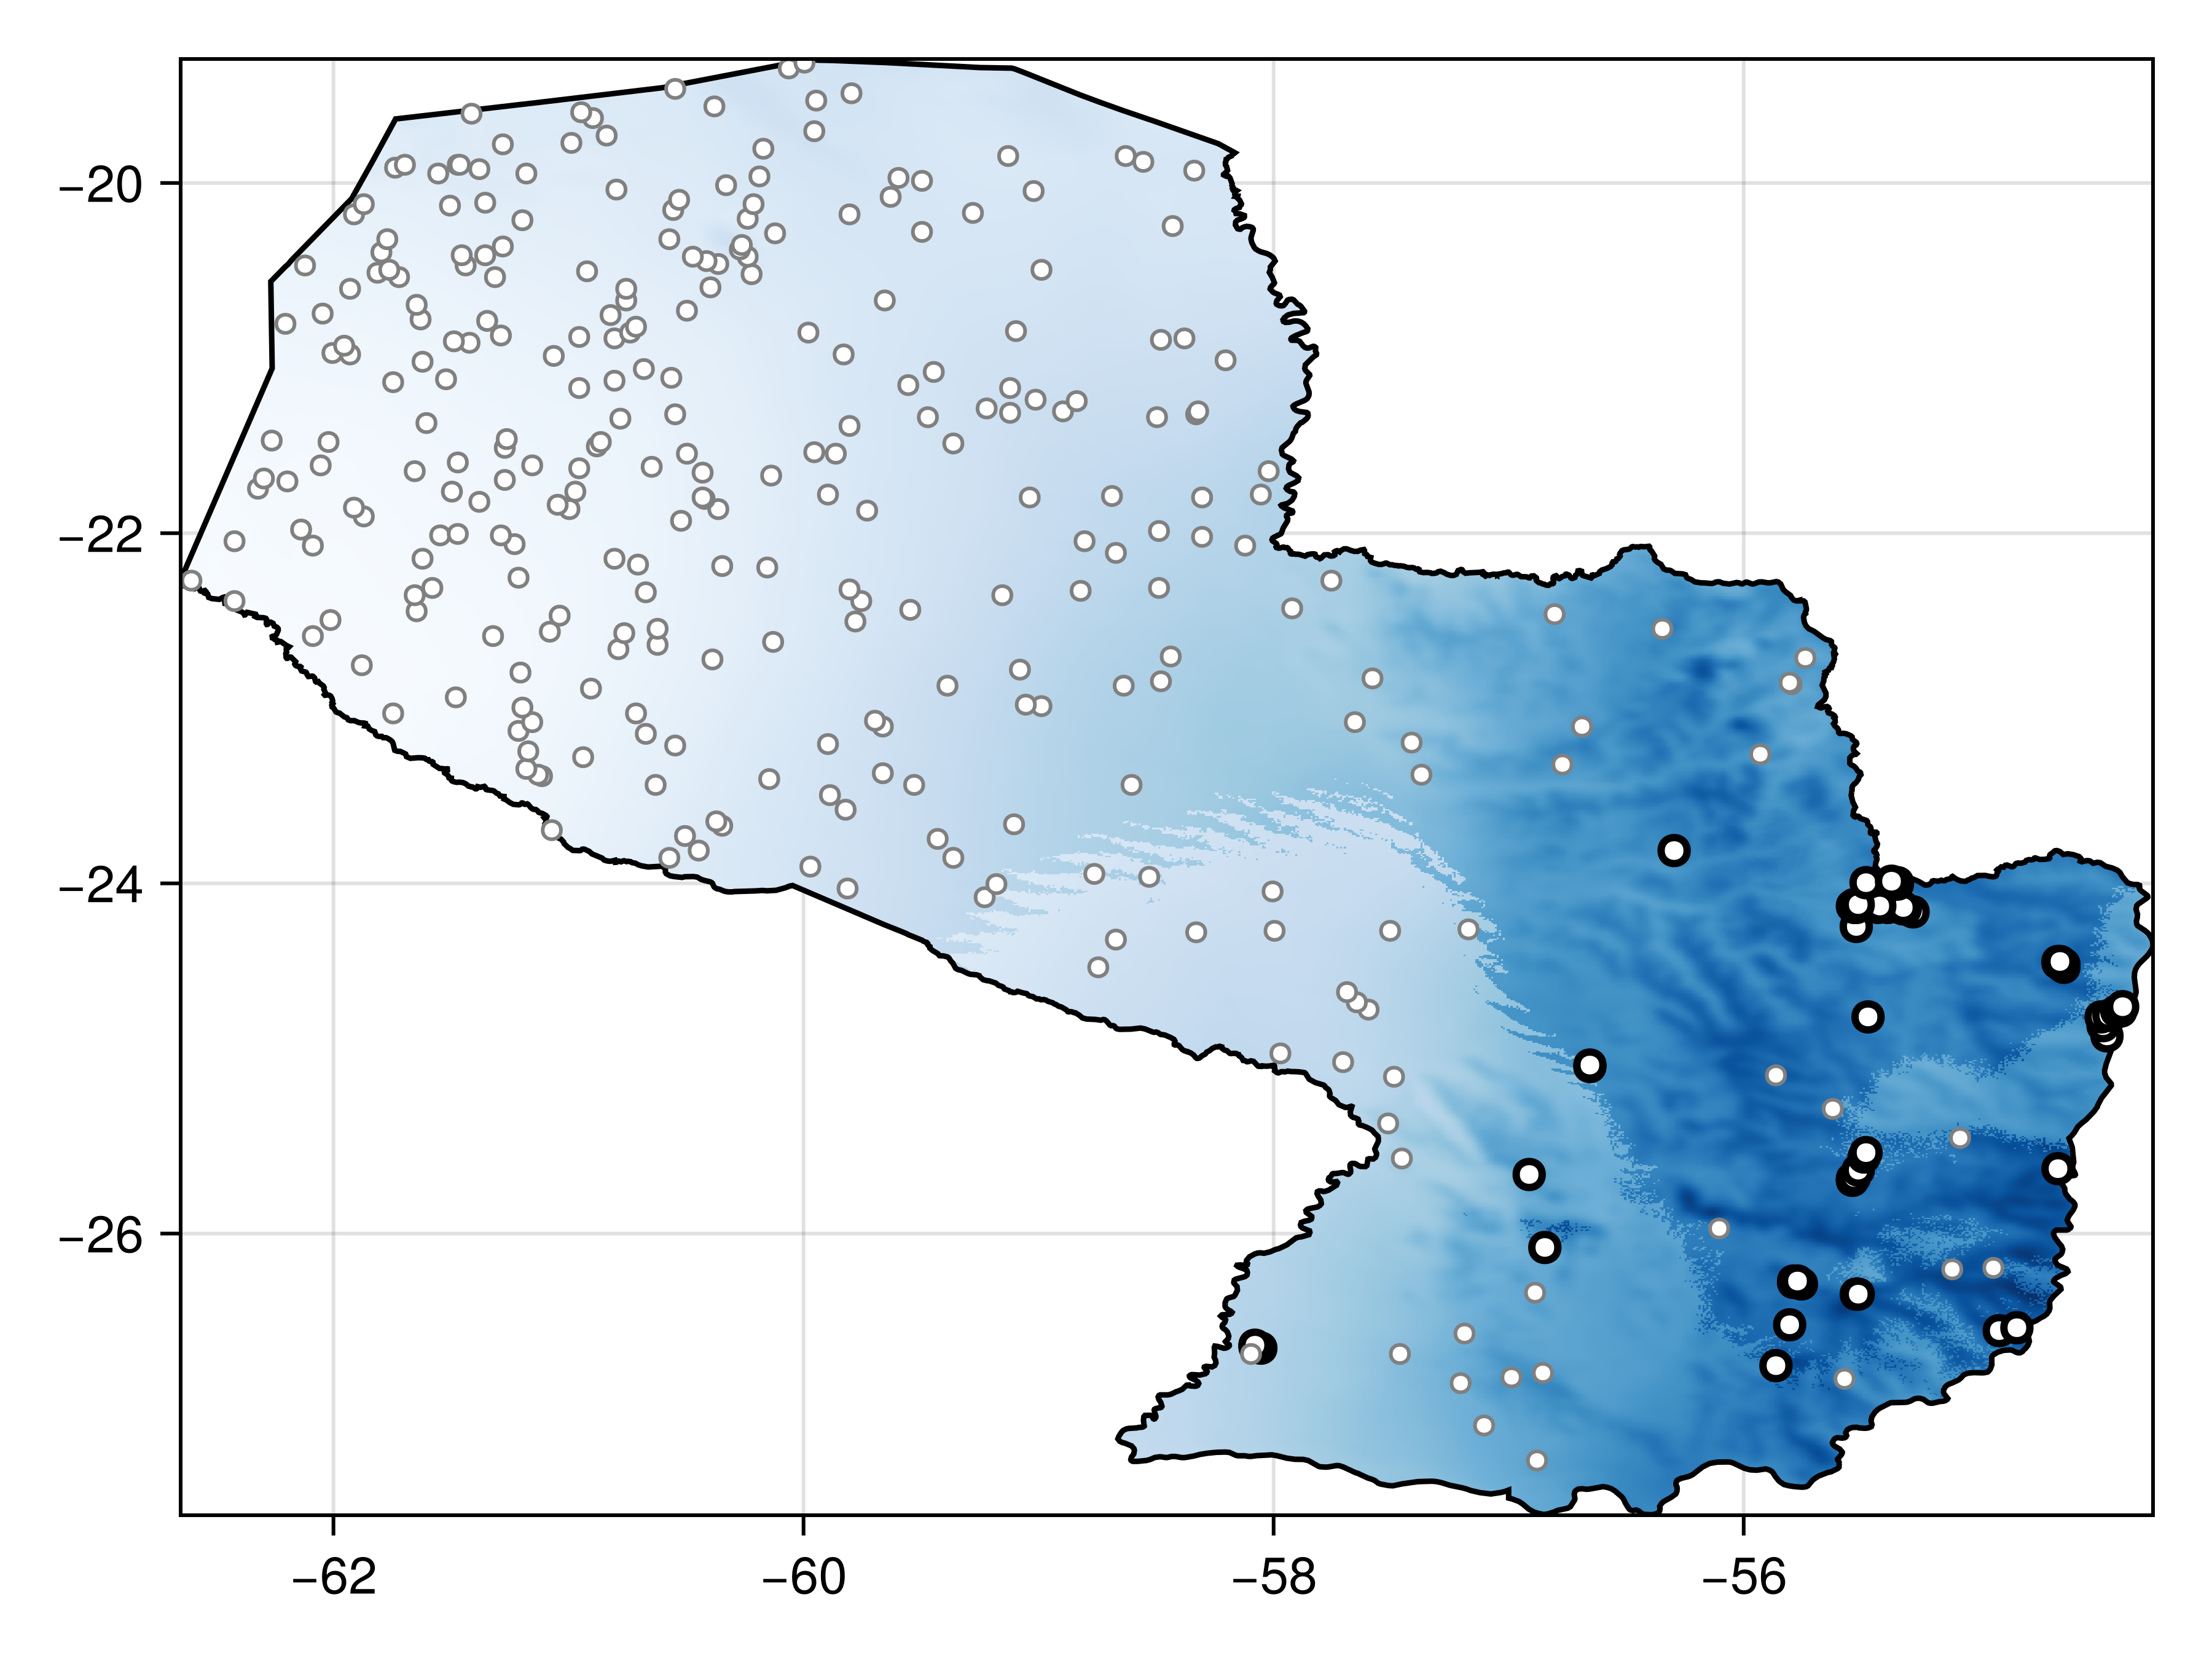

In [163]:
# Illustration
heatmap(L[end], colormap=:Blues)
lines!(place[1].geometry, color=:black)
scatter!(presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
scatter!(bgpoints, color=:white, strokecolor=:grey, strokewidth=1, markersize=7, label="Pseudo-absences")
current_figure()

In [164]:
# Specification of the SDM
sdm = SDM(PCATransform, DecisionTree, L, presencelayer, bgpoints)

PCATransform → DecisionTree → P(x) ≥ 0.5

In [165]:
# Cross-validation
folds = kfold(sdm);
cv = crossvalidate(sdm, folds; threshold = true);
mean(mcc.(cv.validation))

0.7909796019608796

In [166]:
# Variable selection and cross-validation
reset!(sdm)
forwardselection!(sdm, folds)
cv2 = crossvalidate(sdm, folds; threshold = true);
mean(mcc.(cv2.validation))

0.8715263702638776

In [167]:
# Inspection of selected variables
variables(sdm)

3-element Vector{Int64}:
 15
  4
  2

In [168]:
# Final re-training
train!(sdm)

PCATransform → DecisionTree → P(x) ≥ 0.335

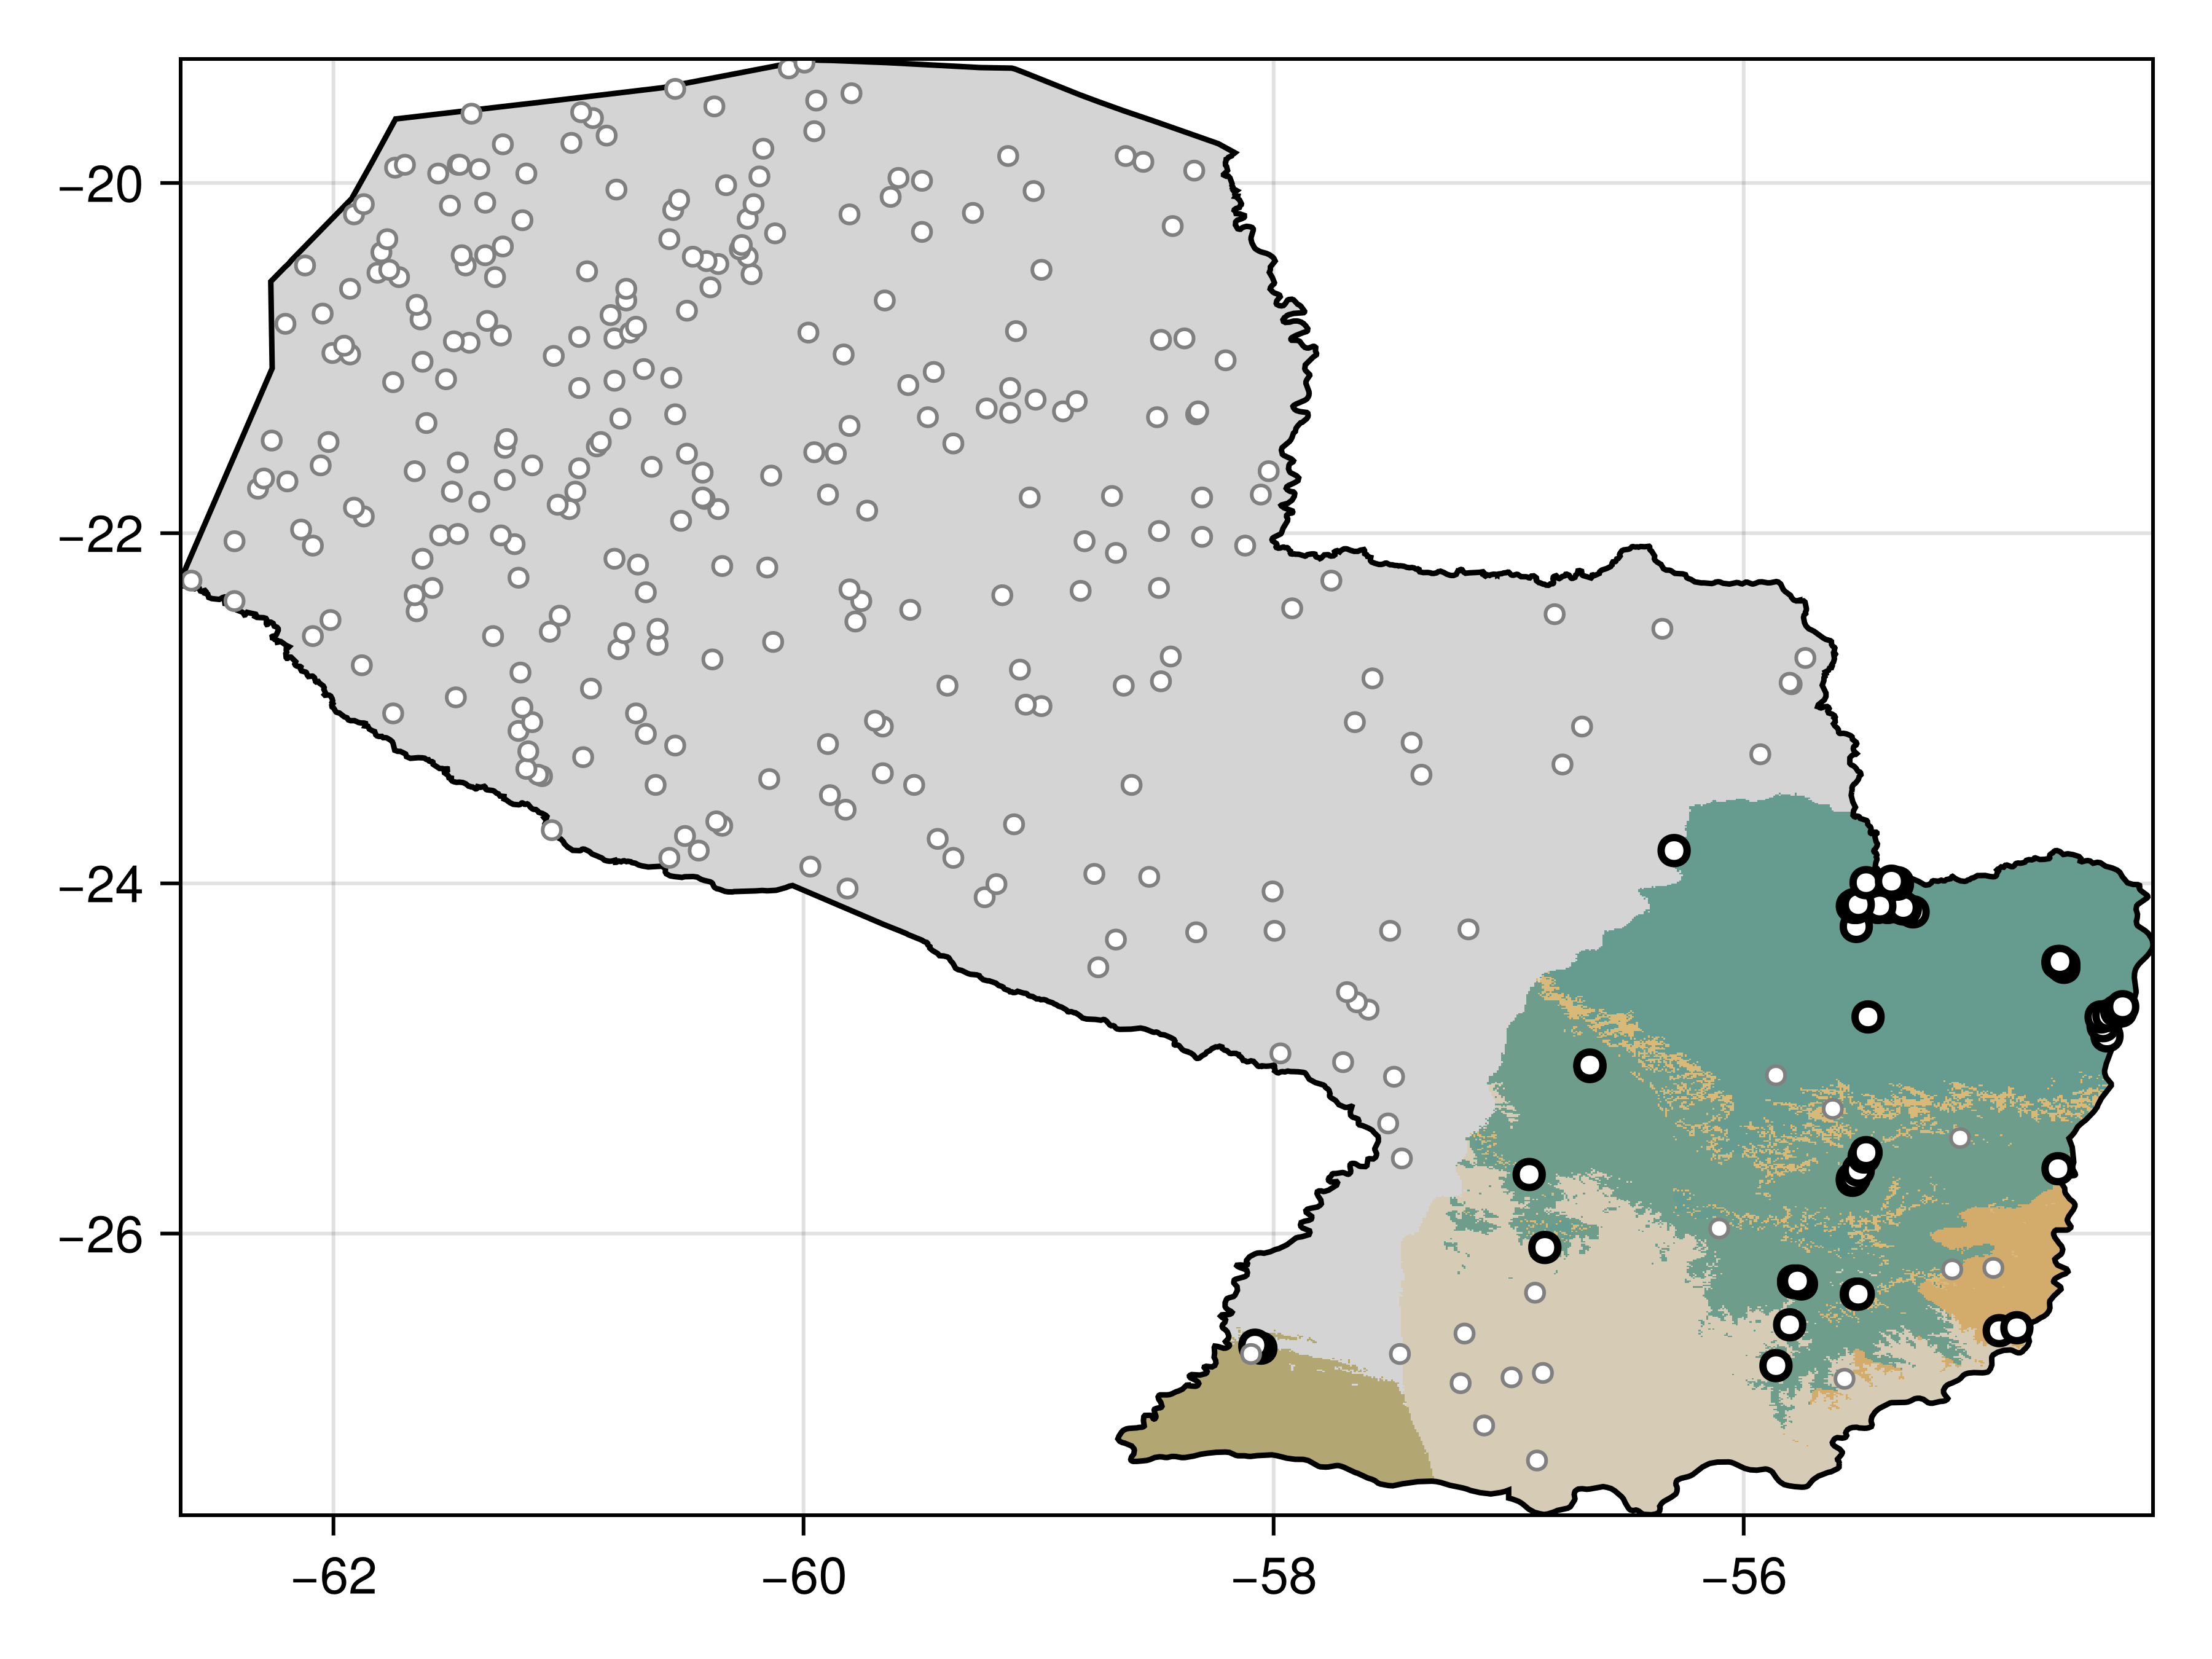

In [169]:
# Initial prediction (decision tree)
heatmap(predict(sdm, L; threshold=false), colormap=Reverse(:linear_gow_60_85_c27_n256))
lines!(place[1].geometry, color=:black)
scatter!(presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
scatter!(bgpoints, color=:white, strokecolor=:grey, strokewidth=1, markersize=7, label="Pseudo-absences")
current_figure()

In [170]:
# Setting up the ensemble
ensemble = Bagging(sdm, 30)
bagfeatures!(ensemble)

{PCATransform → DecisionTree → P(x) ≥ 0.335} × 31

In [171]:
# Training of the ensemble
train!(ensemble)

{PCATransform → DecisionTree → P(x) ≥ 0.335} × 31

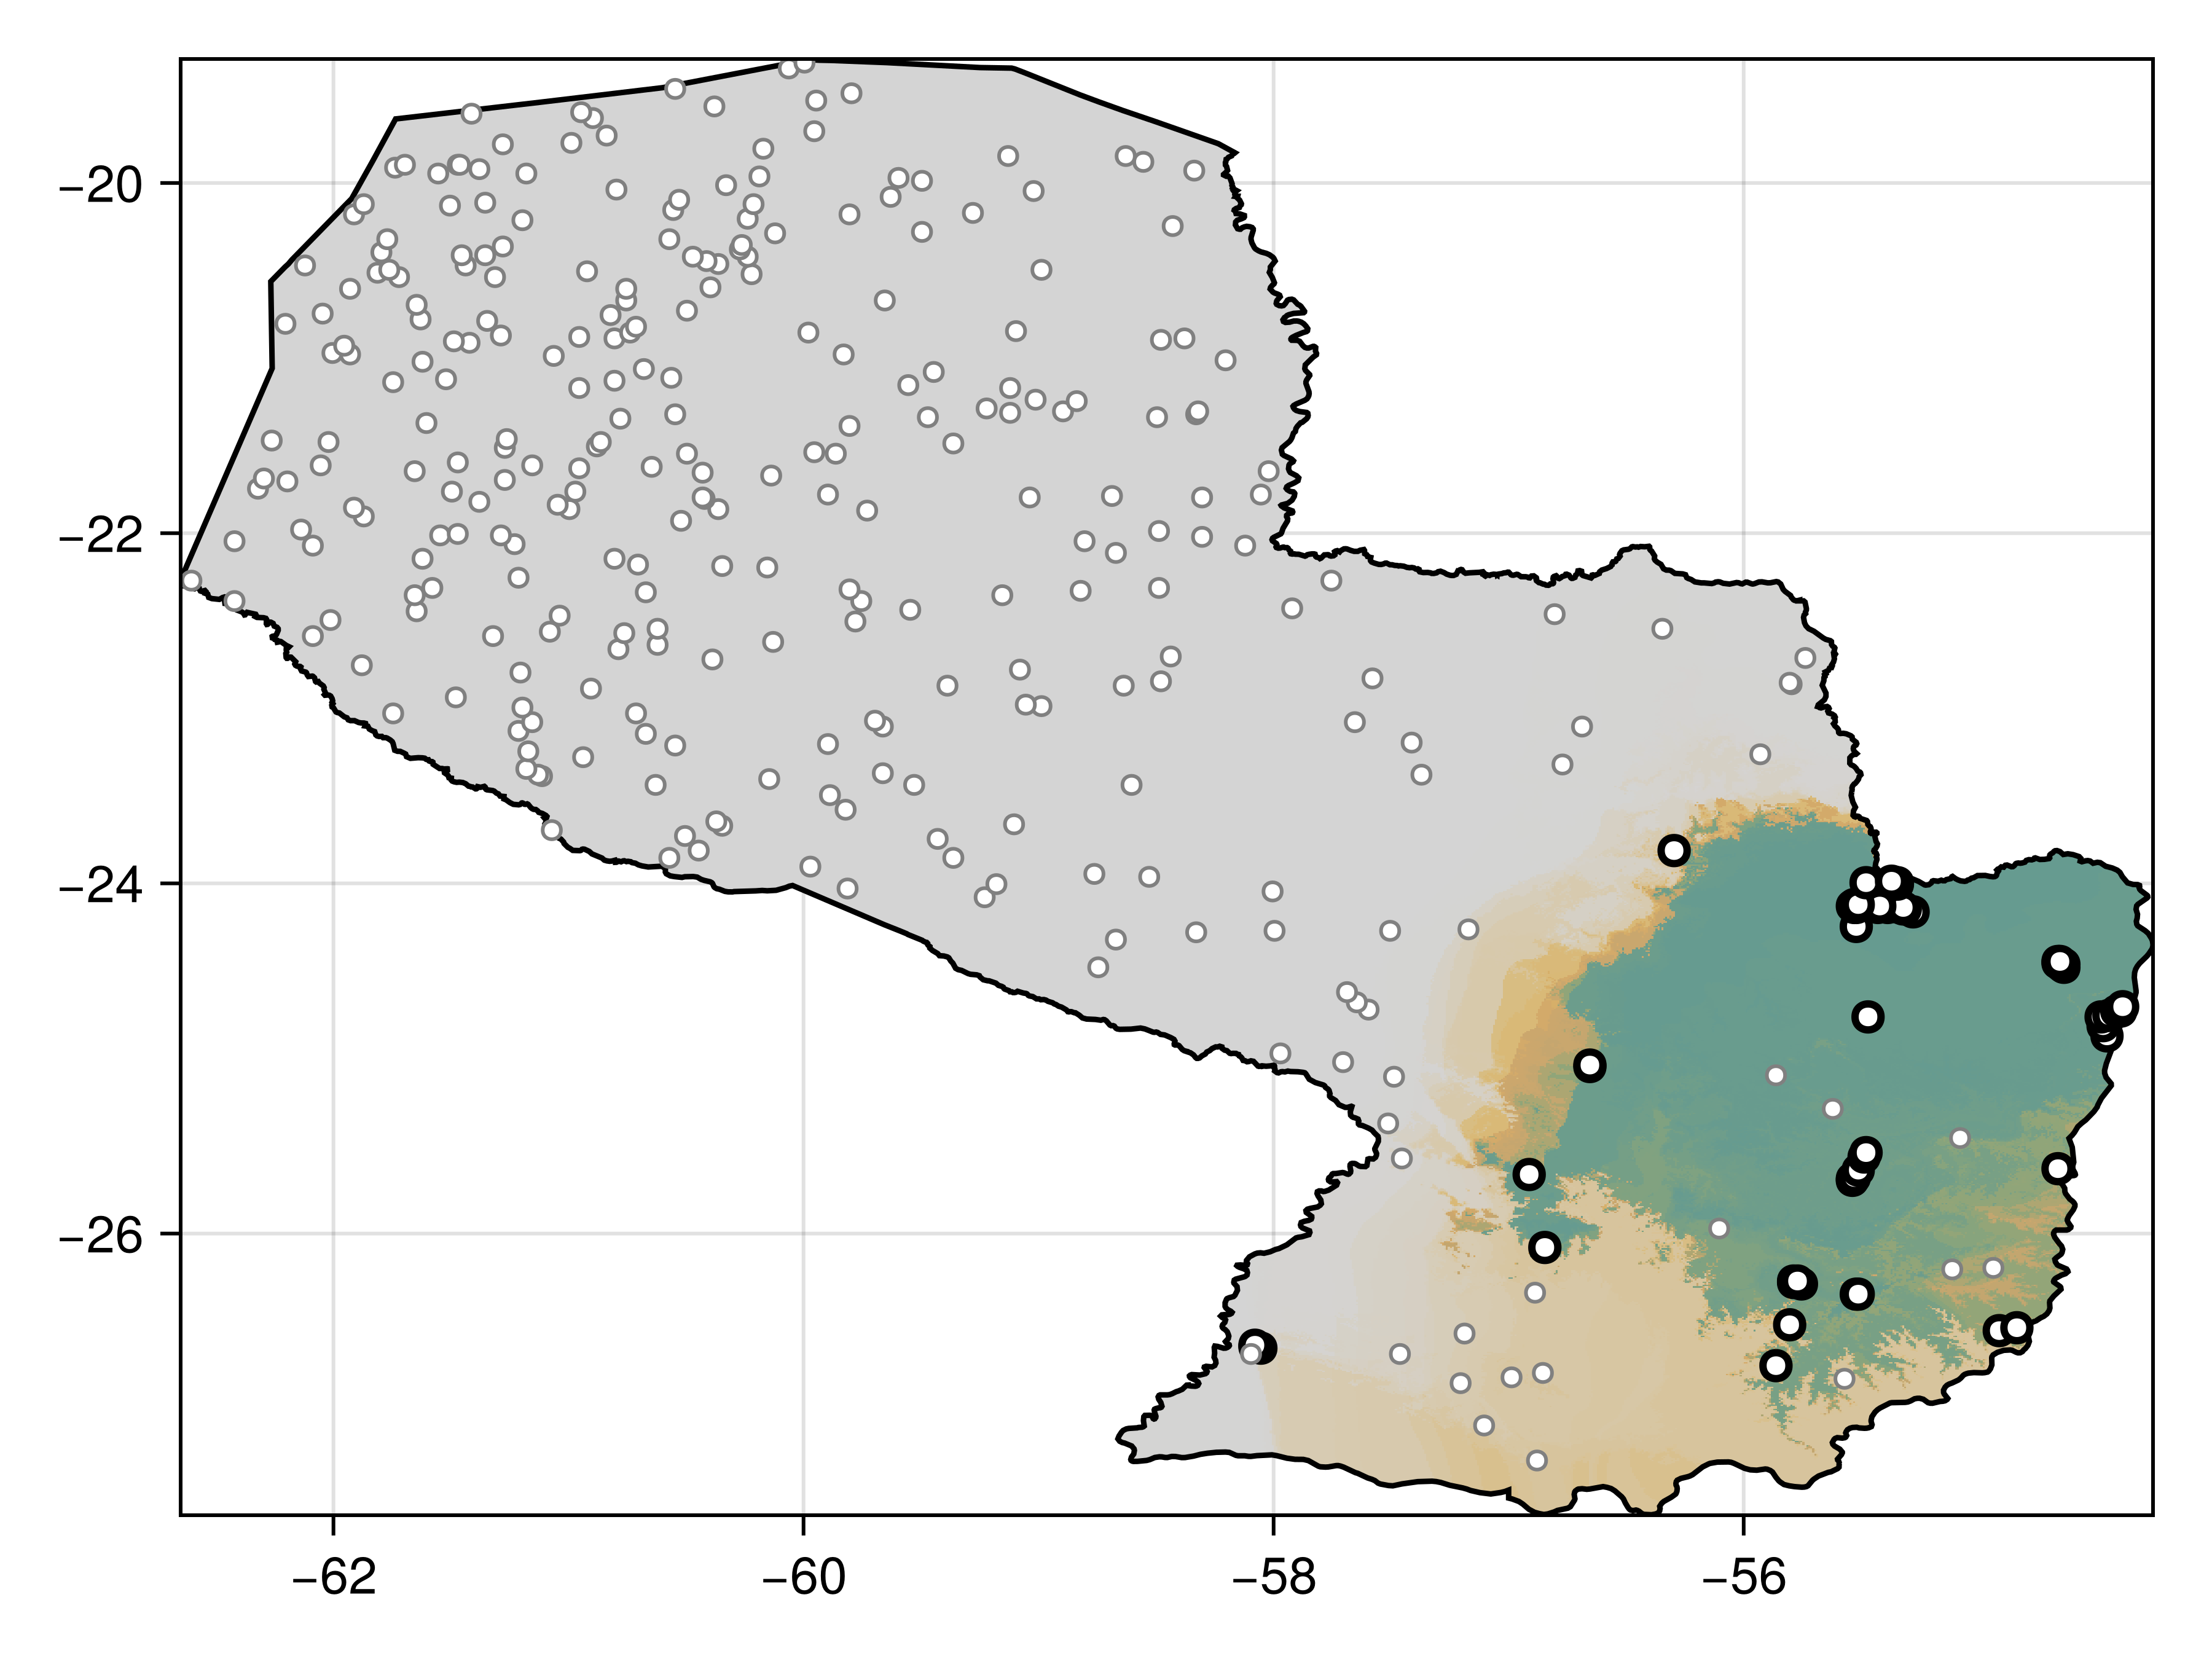

In [172]:
# Predictions of the ensemble
uncertainty = predict(ensemble, L; threshold=false)
heatmap(uncertainty, colormap=Reverse(:linear_gow_60_85_c27_n256))
lines!(place[1].geometry, color=:black)
scatter!(presencelayer, color=:white, strokecolor=:black, strokewidth=2, markersize=10, label="Virtual presences")
scatter!(bgpoints, color=:white, strokecolor=:grey, strokewidth=1, markersize=7, label="Pseudo-absences")
current_figure()

In [173]:
# Get the elevation data
elevprov = RasterData(WorldClim2, Elevation)
elev = convert(SDMLayer{Float16}, SDMLayer(elevprov; resolution=0.5, extent...))

SDM Layer with 1004986 Float16 cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (998, 1007)

In [175]:
# Project the elevation data
elevation = similar(L[1], Float16)
interpolate!(elevation, elev)
mask!(elevation, place)
heatmap(elevation, colormap=:darkterrain)

UndefVarError: UndefVarError: `interpolate!` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Interpolations in the current active module Main

In [156]:
# Get the elevation range
elevation_range = extrema(elevation[presences])

(Float16(60.0), Float16(458.5))

In [157]:
# Calculate final range (climate and elevation)
in_range = predict(ensemble, L; threshold=true, consensus=majority)
in_elev = (e -> (elevation_range[1] <= e <= elevation_range[2])).(elevation)

SDM Layer with 1002986 Bool cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (998, 1007)

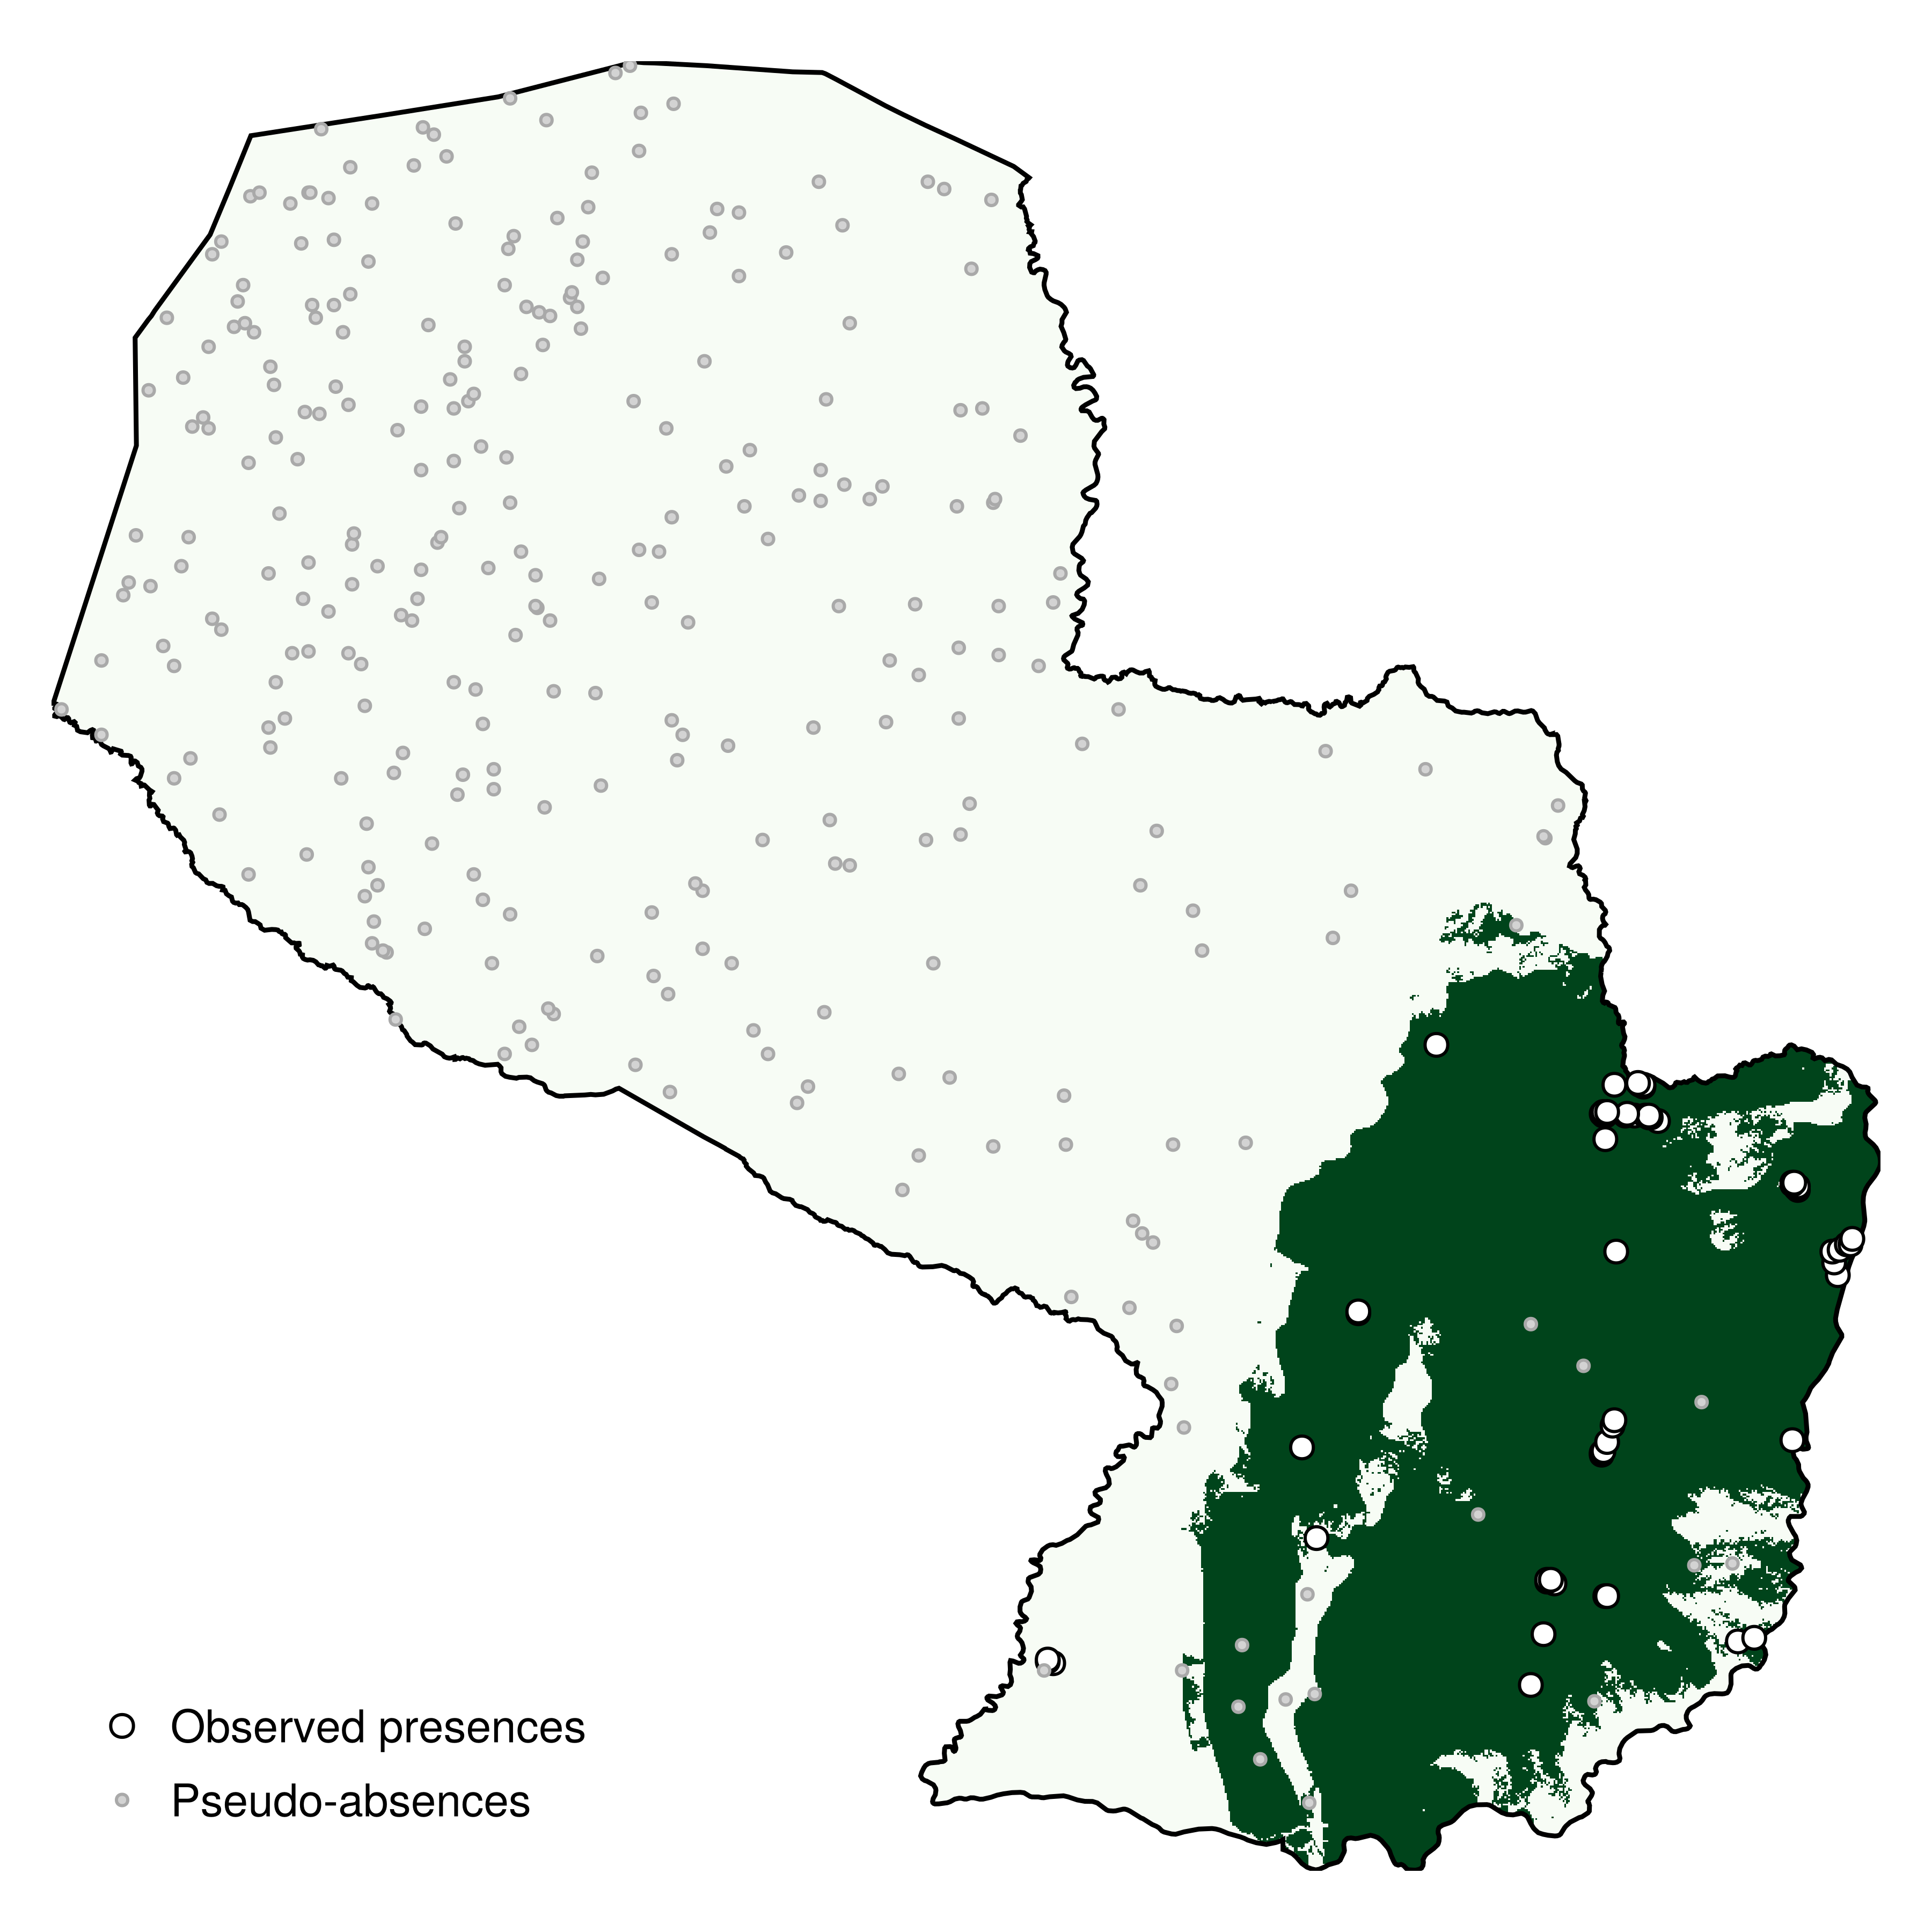

In [158]:
#| label: fig-sdm-output
#| fig-cap: "Predicted range of *Akodon montensis* in Paraguay based on a rotation forest trained on GBIF occurrences and the BioClim variables. The predicted range is clipped to the elevational range of the species. The code to produce this ﬁgure is available as Supp. Mat. 3."
f = Figure(; size=(600, 600))
ax = Axis(f[1,1], aspect=DataAspect())
heatmap!(ax, in_range .& in_elev, colormap=:Greens)
lines!(ax, place[1].geometry, color=:black)
scatter!(ax, presencelayer, color=:white, strokecolor=:black, strokewidth=1, markersize=10, label="Observed presences")
scatter!(ax, bgpoints, color=:lightgrey, strokecolor=:darkgrey, strokewidth=1, markersize=5, label="Pseudo-absences")
axislegend(ax, position=:lb, framevisible=false)
tightlimits!(ax)
hidespines!(ax)
hidedecorations!(ax)
f

In [159]:
vi = variableimportance(ensemble, folds)
vi ./= sum(vi)

3-element Vector{Float64}:
 0.9770433389655936
 0.021761643746729186
 0.0011950172876773013

In [160]:
mix = findmax(vi)

(0.9770433389655936, 1)

In [161]:
si = clamp.(explain(ensemble, variables(sdm)[mix[2]]; threshold=false, samples=100) .+ mean(predict(ensemble; threshold=false)), 0, 1)

353-element Vector{Float64}:
 0.02902835971033005
 0.02933466458760936
 0.04928850058758878
 0.7546400739098506
 0.43985075753954384
 0.530981745233665
 0.5427667492827704
 0.4337317882263906
 0.5687884793353553
 0.6860459897178316
 ⋮
 0.8904915846476312
 0.03631845606744524
 0.10589215318646461
 0.0519052390837646
 0.8686278269124449
 0.43563355468778686
 0.49299597487368685
 0.7331895839302401
 0.41295143713218463

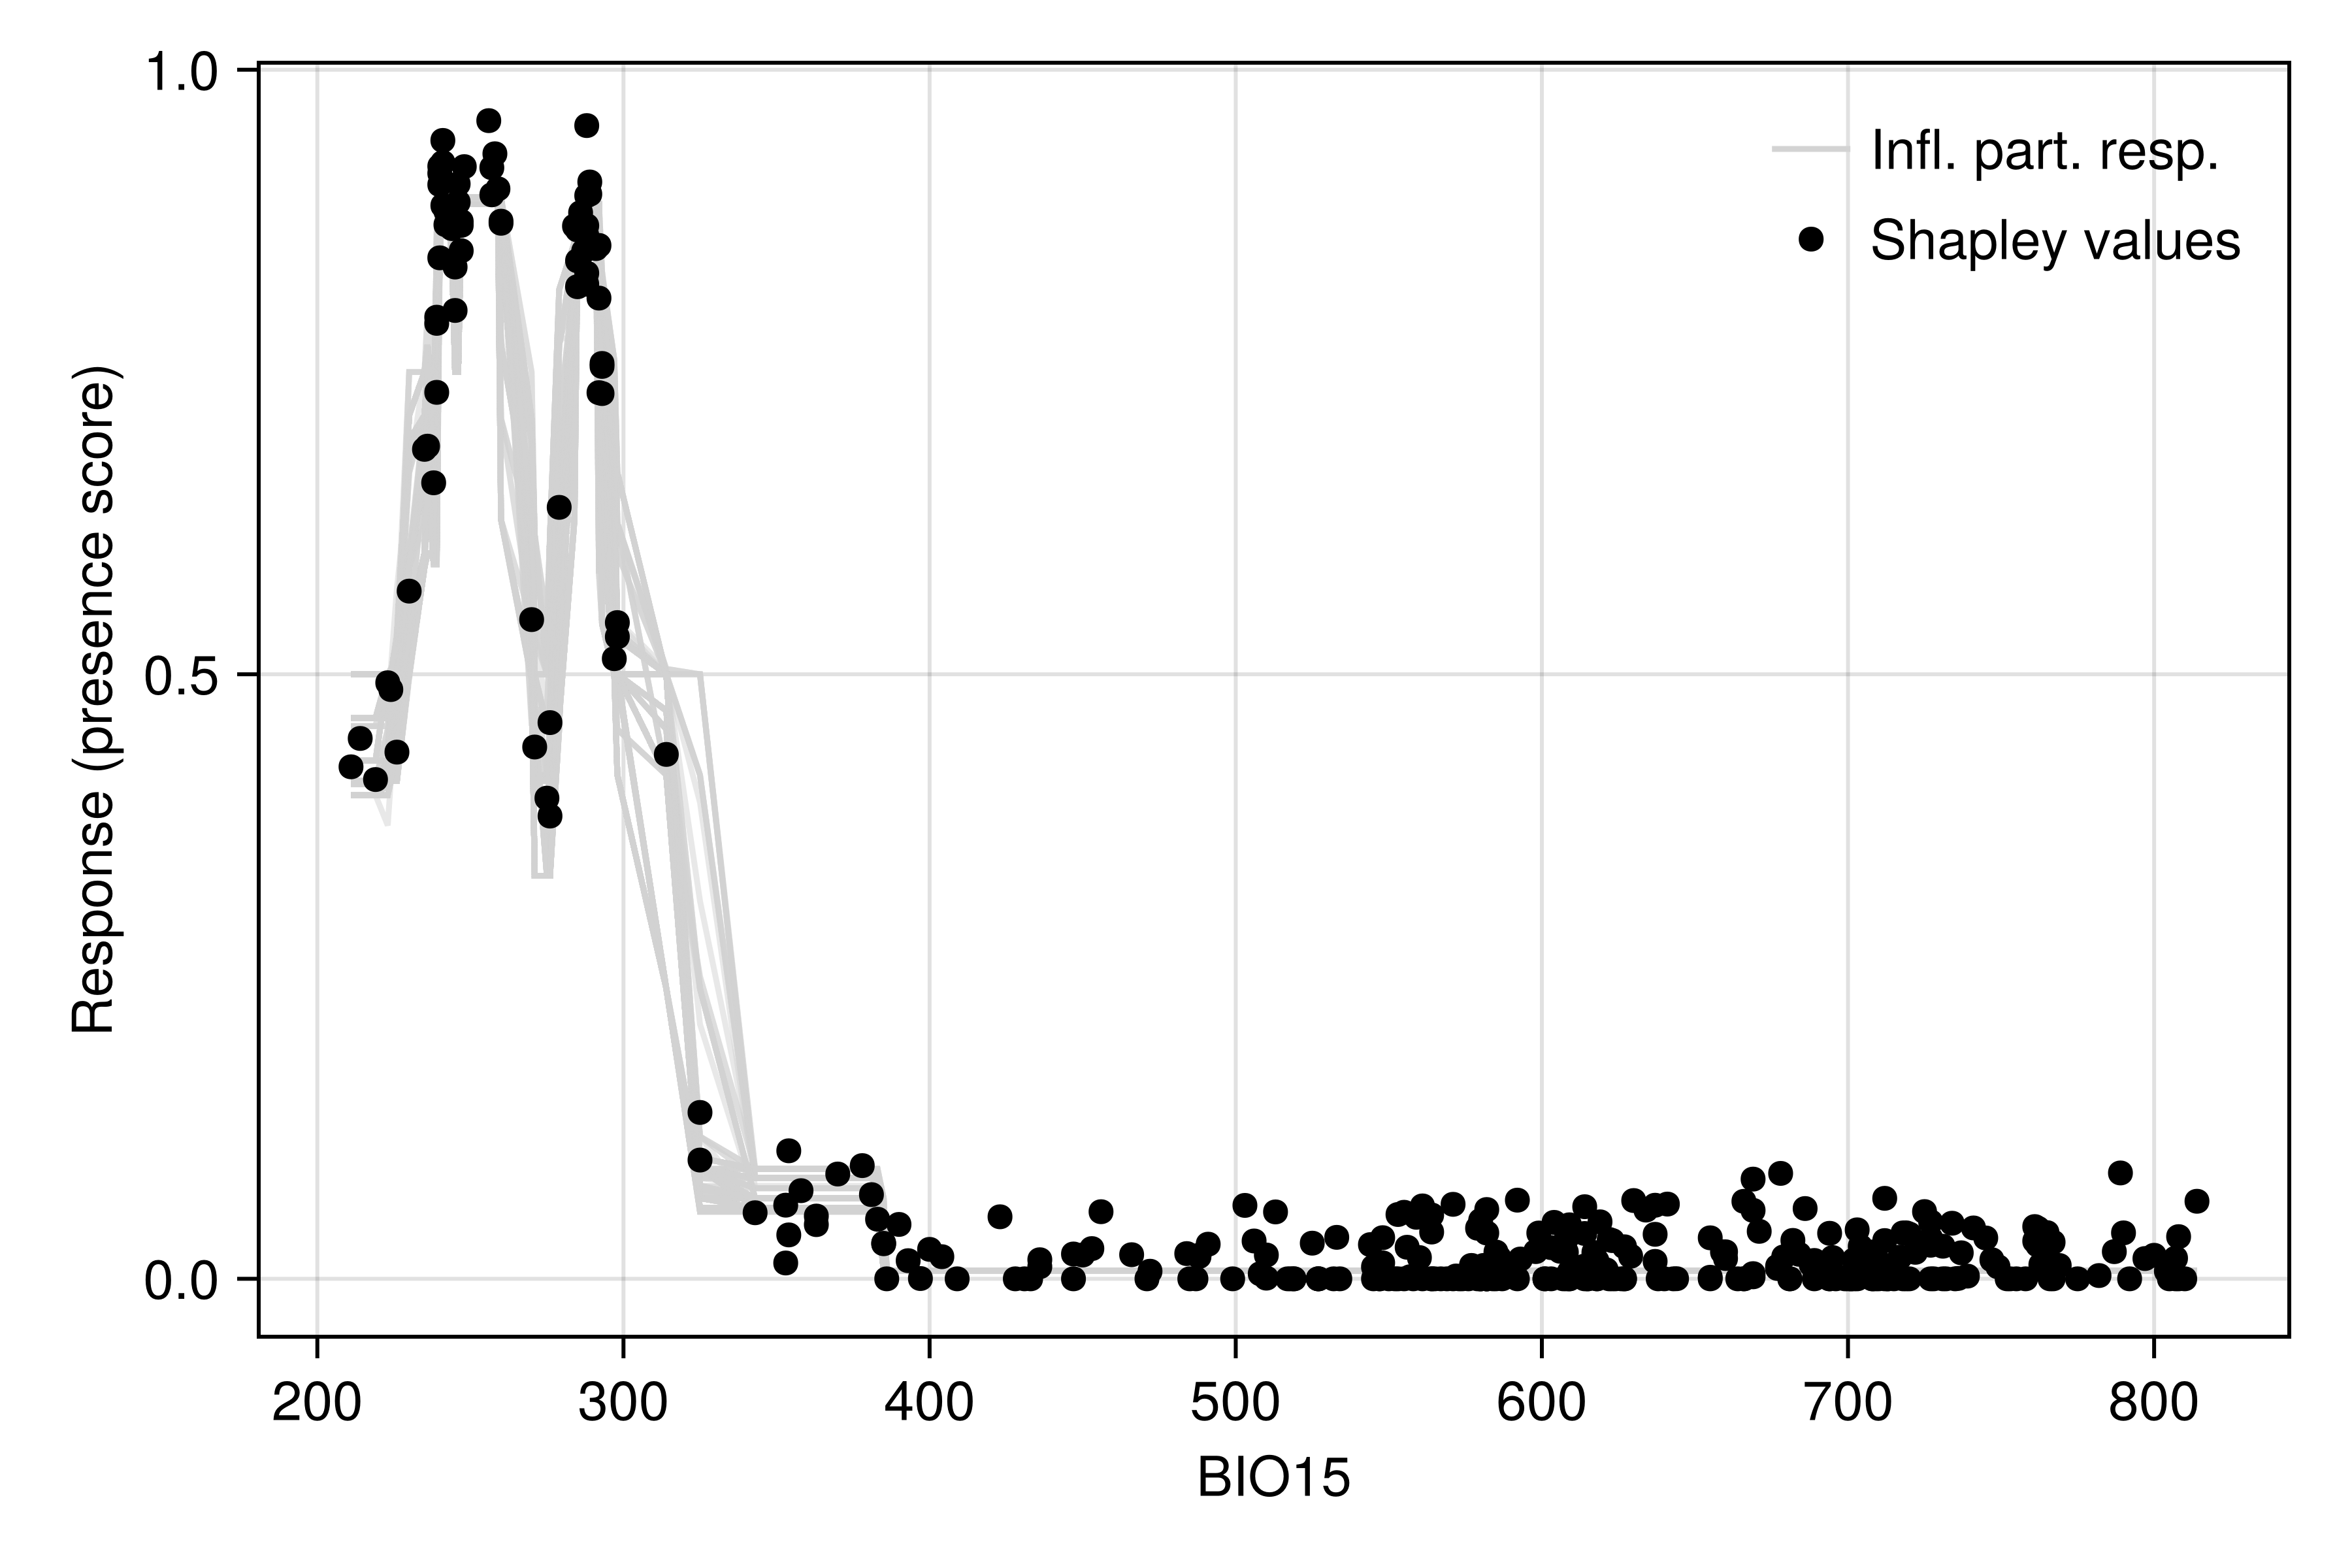

In [162]:
#| label: fig-sdm-responses
#| fig-cap: "Partial responses (black) and inflated partial responses (grey) to the most important variable. In addition, the Shapley values for all training data are presented in the same figure (Shapley values were added to the average model prediction to be comparable to partial responses). The code to produce this ﬁgure is available as Supp. Mat. 3."
fig = Figure(; size = (600, 400))
ax = Axis(fig[1,1], xlabel="BIO$(variables(ensemble)[mix[2]])", ylabel="Response (presence score)")
for _ in 1:200
    lines!(ax, partialresponse(ensemble, variables(sdm)[mix[2]]; threshold=false, inflated=true)..., color=:lightgrey, alpha=0.5, label="Infl. part. resp.")
end
#lines!(ax, partialresponse(ensemble, variables(sdm)[mix[2]]; threshold=false)..., color=:black, label="Part. resp.", linestyle=:dotted)
scatter!(ax, features(ensemble, variables(sdm)[mix[2]]), si, label="Shapley values", color=:black)
axislegend(ax, position=:rt, framevisible=false, merge=true, unique=true)
fig